## Import them all

In [109]:
import numpy as np
import torch

from PIL import Image
from argparse import ArgumentParser

from torch.optim import SGD, Adam
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import Compose, CenterCrop, Normalize
from torchvision.transforms import ToTensor, ToPILImage


from piwise.network import UNet
from piwise.criterion import CrossEntropyLoss2d
from piwise.transform import Relabel, ToLabel, Colorize
from random import randint
import matplotlib.pyplot as plt
import random

## Setup the model

In [61]:
NUM_CHANNELS = 2
NUM_CLASSES = 2

Net = UNet
model = Net(NUM_CLASSES)
model = model.cuda()




# Load the Data

In [241]:
in_arr = np.load('data/inputs.npy')
out_arr = np.load('data/outputs.npy')
out_arr[out_arr==2]=0
in_test = np.zeros([3,2,512,512]).astype(float)
out_test = np.zeros([3,512,512]).astype(float)

random.seed(1)
for i in range(0,3):
    r = randint(0,(12-i)-1)
    tempIn = in_arr[r]
    tempOut = out_arr[r]
    in_test[i]=tempIn
    out_test[i]=tempOut
    mask = np.ones(len(in_arr), dtype=bool)
    mask[r]=False
    in_arr = in_arr[mask,...]
    out_arr = out_arr[mask,...]
    
in_train = torch.from_numpy(in_arr)
out_train = torch.from_numpy(out_arr).long()
in_test = torch.FloatTensor(in_test)
out_test = torch.FloatTensor(out_test).long()
loader = DataLoader(TensorDataset(in_train,out_train), shuffle=True)

images, labels = next(iter(loader))

In [118]:
random.seed(1)
for i in range(0,3):
    r = randint(0,len(in_arr)-1)
    tempIn = in_arr[r]
    tempOut = out_arr[r]
    in_test[i]=tempIn
    out_test[i]=tempOut
    mask = np.ones(len(in_arr), dtype=bool)
    mask[r]=False
    in_arr = in_arr[mask,...]
    out_arr = out_arr[mask,...]
in_train = torch.from_numpy(in_arr)
out_train = torch.from_numpy(out_arr).long()

In [242]:
in_test


( 0 , 0 ,.,.) = 
  0.1576  0.1609  0.1595  ...   0.1527  0.1221  0.1210
  0.1669  0.1743  0.1718  ...   0.1393  0.1431  0.1475
  0.1637  0.1859  0.2019  ...   0.1319  0.1333  0.1397
           ...             ⋱             ...          
  0.1550  0.1594  0.1661  ...   0.1297  0.1332  0.1329
  0.1543  0.1581  0.1646  ...   0.1502  0.1586  0.1269
  0.1567  0.1609  0.1619  ...   0.1492  0.1265  0.1195

( 0 , 1 ,.,.) = 
  0.5196  0.5322  0.5758  ...   0.5475  0.5194  0.5164
  0.4797  0.4327  0.4592  ...   0.4437  0.4377  0.4773
  0.5348  0.4103  0.3350  ...   0.4139  0.4511  0.5360
           ...             ⋱             ...          
  0.5367  0.3762  0.2431  ...   0.3807  0.4151  0.5322
  0.5775  0.4369  0.3519  ...   0.4785  0.4472  0.5495
  0.5831  0.5019  0.4792  ...   0.5653  0.5218  0.5676
      ⋮  

( 1 , 0 ,.,.) = 
  0.1586  0.1590  0.1593  ...   0.1476  0.1476  0.1472
  0.1620  0.1626  0.1630  ...   0.1490  0.1490  0.1485
  0.1765  0.1759  0.1913  ...   0.1591  0.1680  0.1528
 

In [222]:
r

1

In [89]:
test.shape

(12, 2, 512, 512)

In [9]:
images.size()

torch.Size([1, 2, 512, 512])

In [10]:
labels.size()

torch.Size([1, 512, 512])

In [126]:
labels.max()

2

# Train the model

In [252]:
model.train()
weight = torch.ones(NUM_CLASSES)
weight[0] = 0      
criterion = CrossEntropyLoss2d()
optimizer = Adam(model.parameters())
epoch_loss = []
for epoch in range(1, 1201):
    

    for step, (images, labels) in enumerate(loader):
        images = images.cuda()
        labels = labels.cuda()

        inputs = Variable(images)
        targets = Variable(labels)
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()
        
        epoch_loss.append((loss.data[0]))
torch.save(epoch_loss, "loss")
print("Training complete.")

/opt/conda/envs/pytorch-py36/lib/python3.6/site-packages/torch/nn/functional.py:807: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.")


Training complete.


# Evaluate the model

In [299]:
n = 1
model.eval()
input = in_test[n].cuda()
output = model(Variable(input).unsqueeze(0))
target = out_test[n]

print("Evaluation complete.")

Evaluation complete.


/opt/conda/envs/pytorch-py36/lib/python3.6/site-packages/torch/nn/functional.py:807: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.")


# Process Results

In [300]:
in_data = input.cpu().numpy()
out_data = output.data.cpu().numpy()
tgt_data = target.cpu().numpy()

in_data_avg = in_data[0]
in_data_corr = in_data[1]

indicator  =  np.arange(out_data.shape[1]).reshape([1, -1, 1, 1])
np.sum(out_data*indicator, axis=1)
x = np.exp(out_data)
res = x/x.sum(1)

pos = np.argmax(res, axis=1)


# Plot Results

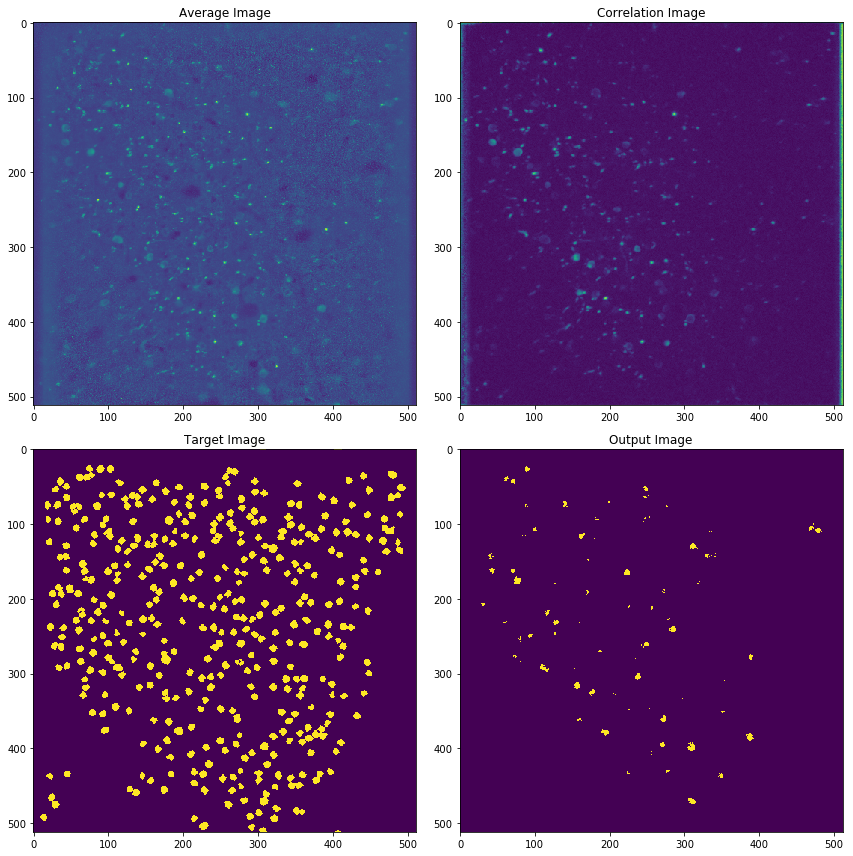

In [319]:
plt.figure()

plt.subplots(figsize=(12,12))

avg = plt.subplot(221)
corr = plt.subplot(222)
tgt = plt.subplot(223)
out = plt.subplot(224)


avg.title.set_text("Average Image")
corr.title.set_text("Correlation Image")
tgt.title.set_text("Target Image")
out.title.set_text("Output Image")

avg.imshow(in_data_avg)
corr.imshow(in_data_corr)
tgt.imshow(tgt_data)
out.imshow(pos.squeeze())



plt.tight_layout()



In [44]:
%matplotlib inline

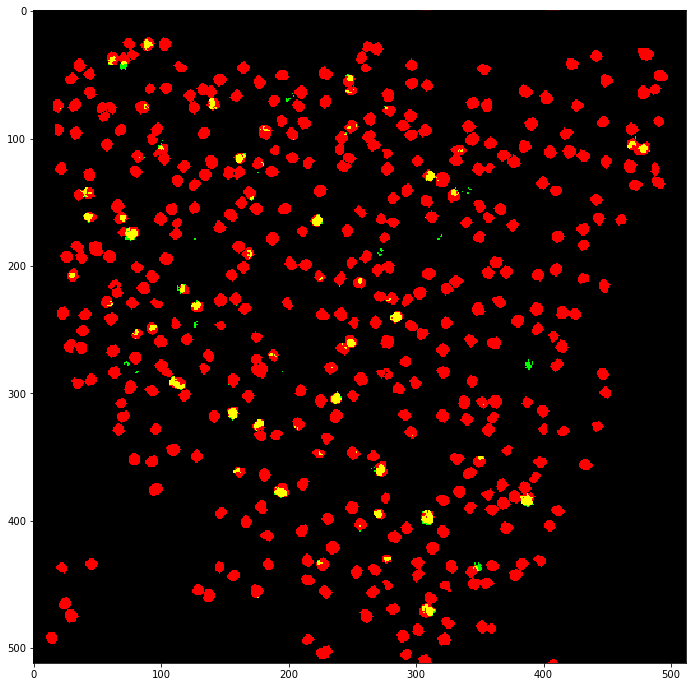

In [379]:
overlap = np.zeros((512,512, 3))
out_image= pos.squeeze()
for h in range(0, 512):
    for w in range(0, 512):
        overlap[w][h][0]=tgt_data[w][h]
        overlap[w][h][1]=out_image[w][h]
fig = plt.figure(figsize=(12, 12))
plt.imshow(overlap)

In [304]:
fig = plt.figure(figsize=(12,12))

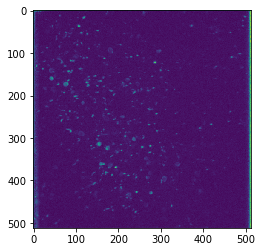

In [305]:
plt.imshow(in_data_corr)

In [172]:
x[0]

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [173]:
x[2]

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [175]:
x[0]

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [176]:
x[1]

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [177]:
out_image

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [196]:
x[0]

array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.]])

In [197]:
x[0].shape

(512, 3)

In [198]:
x[511][511][0]

0.0

In [202]:
tgt_data[0][0]

0

In [293]:
x[x==1].sum()

181382.0

In [210]:
overlap.add_axes()

In [212]:
overlap.add_subplot(111)

In [218]:
img = overlap.subplot(111)

AttributeError: 'Figure' object has no attribute 'subplot'

In [214]:
img

In [215]:
img.imshow(x)

In [240]:
img.imshow(x)

In [242]:
overlap.figimage(x)

AttributeError: 'FigureImage' object has no attribute 'show'

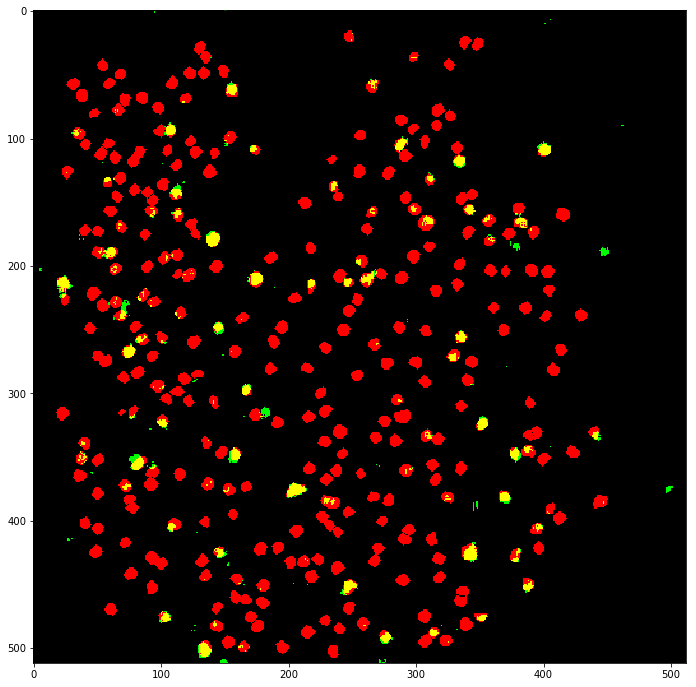

In [1]:
epoch_loss

NameError: name 'epoch_loss' is not defined

In [6]:
test = torch.Tensor(3,4)

In [7]:
test


-2.9096e+07  4.5897e-41 -2.9096e+07  4.5897e-41
 4.2039e-45  1.5134e-43  6.1124e-37  0.0000e+00
 0.0000e+00  0.0000e+00  0.0000e+00  1.4013e-45
[torch.FloatTensor of size 3x4]

In [8]:
import torch.serialization

In [10]:
torch.save(test, "test")

In [12]:
torch

<module 'torch' from '/opt/conda/envs/pytorch-py36/lib/python3.6/site-packages/torch/__init__.py'>

In [13]:
loss

Variable containing:
1.00000e-02 *
  3.3721
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [14]:
epoch_loss

[0.6689267158508301,
 0.6417156457901001,
 0.6051234006881714,
 0.5085488557815552,
 0.338493287563324,
 0.5750184059143066,
 0.4159592390060425,
 0.38193103671073914,
 0.39681053161621094,
 0.3668211102485657,
 0.38717833161354065,
 0.3440293073654175,
 0.323546826839447,
 0.357455313205719,
 0.3705185055732727,
 0.30262070894241333,
 0.3174171447753906,
 0.33194854855537415,
 0.3031551241874695,
 0.37096184492111206,
 0.29911506175994873,
 0.3725431561470032,
 0.3416788578033447,
 0.3773483633995056,
 0.36318281292915344,
 0.3297520875930786,
 0.3730587065219879,
 0.3488506078720093,
 0.34634435176849365,
 0.28933680057525635,
 0.38015949726104736,
 0.3726849853992462,
 0.31215327978134155,
 0.2965962886810303,
 0.28294774889945984,
 0.3009120225906372,
 0.3443964719772339,
 0.30305761098861694,
 0.3006460964679718,
 0.2959049344062805,
 0.28253960609436035,
 0.36696475744247437,
 0.36572766304016113,
 0.372468501329422,
 0.29051241278648376,
 0.3054811358451843,
 0.3422948718070984,

In [151]:
plt.figure(figsize=(12,12))

In [16]:
import matplotlib.pyplot as plt

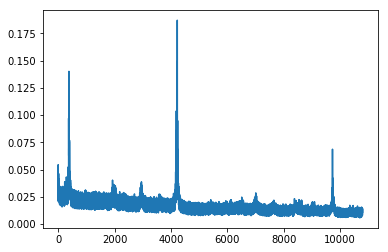

In [152]:
plt.plot(epoch_loss)

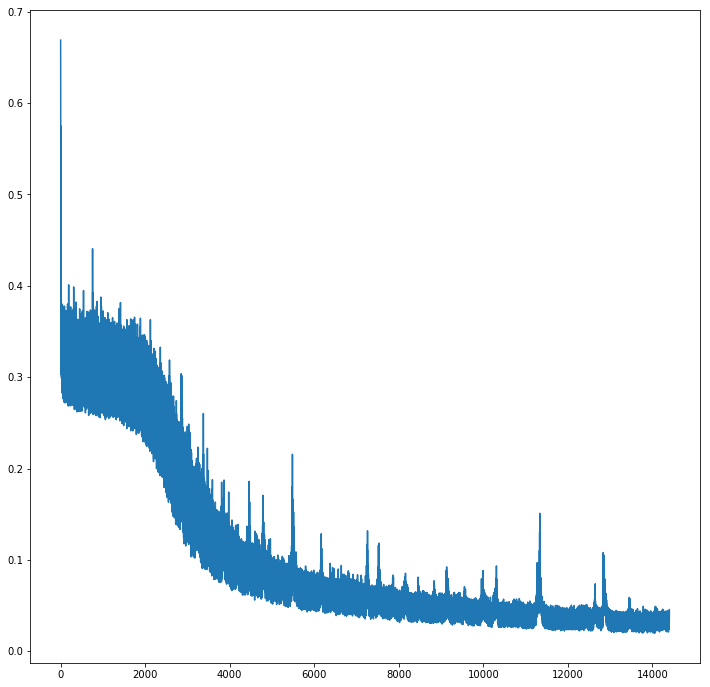

In [19]:
plt.show()

In [20]:
outputs

Variable containing:
( 0 , 0 ,.,.) = 
    0.0000    0.0000    0.0000  ...     0.0000    0.0000    0.0000
    0.0000    0.0000    0.0000  ...     0.0000    0.0000    0.0000
    0.0000    0.0000    0.0000  ...     0.0000    0.0000    0.0000
              ...                ⋱                ...             
    0.0000    0.0000    0.0000  ...     0.0000    0.0000    0.0000
    0.0000    0.0000    0.0000  ...     0.0000    0.0000    0.0000
    0.0000    0.0000    0.0000  ...     0.0000    0.0000    0.0000

( 0 , 1 ,.,.) = 
 -275.8093 -197.0099 -192.1005  ...   -19.0381  -19.4463  -20.7582
 -298.9200 -270.1656 -173.9860  ...   -16.9399  -18.8409  -18.9562
 -304.5207 -261.8327 -215.6767  ...   -16.7768  -18.7681  -22.3424
              ...                ⋱                ...             
 -263.4429 -267.6931 -187.0796  ...   -16.8723  -16.4540  -20.7305
 -251.2043 -251.8668 -179.1356  ...   -18.1548  -19.5589  -21.5987
 -273.2863 -251.5531 -152.4362  ...   -18.7580  -19.6846  -23.5223
[torch

In [25]:
torch.save(targets,"latest_targets")

In [24]:
targets

Variable containing:
( 0 ,.,.) = 
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
[torch.cuda.LongTensor of size 1x512x512 (GPU 0)]

In [13]:
targets = torch.load("latest_targets")

In [36]:
targets

Variable containing:
( 0 ,.,.) = 
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
[torch.cuda.LongTensor of size 1x512x512 (GPU 0)]

In [8]:
outputs = torch.load("latest_outputs")

In [10]:
inputs = torch.load("latest_inputs")

In [1]:
inputs

NameError: name 'inputs' is not defined

In [3]:
import torch

In [6]:
model

UNet (
  (dec1): UNetDec (
    (down): Sequential (
      (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU (inplace)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU (inplace)
      (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    )
  )
  (dec2): UNetDec (
    (down): Sequential (
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU (inplace)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU (inplace)
      (4): Dropout (p = 0.5)
      (5): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    )
  )
  (center): Sequential (
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU (inplace)
    (4): Dropout (p = 0.5)
    (5): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
    (6): ReLU (inplace)
  )
  (enc2): UNetEnc (
    (up): Sequential (
      (

In [11]:
outputs[0]

Variable containing:
( 0 ,.,.) = 
    0.0000    0.0000    0.0000  ...     0.0000    0.0000    0.0000
    0.0000    0.0000    0.0000  ...     0.0000    0.0000    0.0000
    0.0000    0.0000    0.0000  ...     0.0000    0.0000    0.0000
              ...                ⋱                ...             
    0.0000    0.0000    0.0000  ...     0.0000    0.0000    0.0000
    0.0000    0.0000    0.0000  ...     0.0000    0.0000    0.0000
    0.0000    0.0000    0.0000  ...     0.0000    0.0000    0.0000

( 1 ,.,.) = 
 -275.8093 -197.0099 -192.1005  ...   -19.0381  -19.4463  -20.7582
 -298.9200 -270.1656 -173.9860  ...   -16.9399  -18.8409  -18.9562
 -304.5207 -261.8327 -215.6767  ...   -16.7768  -18.7681  -22.3424
              ...                ⋱                ...             
 -263.4429 -267.6931 -187.0796  ...   -16.8723  -16.4540  -20.7305
 -251.2043 -251.8668 -179.1356  ...   -18.1548  -19.5589  -21.5987
 -273.2863 -251.5531 -152.4362  ...   -18.7580  -19.6846  -23.5223
[torch.cuda.Fl

In [14]:
targets

Variable containing:
( 0 ,.,.) = 
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
[torch.cuda.LongTensor of size 1x512x512 (GPU 0)]

In [16]:
tgt_test = targets[0]

In [17]:
in_test = inputs[0]

In [18]:
out_test = model(in_test)

ValueError: Expected 4D tensor as input, got 3D tensor instead.

In [20]:
out_test = model(in_test.unsqueeze(0))

/opt/conda/envs/pytorch-py36/lib/python3.6/site-packages/torch/nn/functional.py:807: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.")


In [21]:
out_test

Variable containing:
( 0 , 0 ,.,.) = 
 -0.6889 -0.6888 -0.6888  ...  -0.6889 -0.6895 -0.6901
 -0.6888 -0.6886 -0.6886  ...  -0.6887 -0.6894 -0.6899
 -0.6884 -0.6882 -0.6881  ...  -0.6885 -0.6891 -0.6897
           ...             ⋱             ...          
 -0.6882 -0.6880 -0.6881  ...  -0.6885 -0.6890 -0.6894
 -0.6881 -0.6880 -0.6880  ...  -0.6884 -0.6889 -0.6893
 -0.6884 -0.6883 -0.6883  ...  -0.6886 -0.6892 -0.6895

( 0 , 1 ,.,.) = 
 -0.6974 -0.6975 -0.6975  ...  -0.6974 -0.6969 -0.6962
 -0.6976 -0.6977 -0.6978  ...  -0.6976 -0.6969 -0.6964
 -0.6980 -0.6981 -0.6982  ...  -0.6979 -0.6972 -0.6966
           ...             ⋱             ...          
 -0.6981 -0.6983 -0.6982  ...  -0.6978 -0.6973 -0.6969
 -0.6982 -0.6983 -0.6983  ...  -0.6979 -0.6974 -0.6970
 -0.6979 -0.6981 -0.6980  ...  -0.6977 -0.6971 -0.6968
[torch.cuda.FloatTensor of size 1x2x512x512 (GPU 0)]

In [22]:
tgt_test

Variable containing:
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
       ...          ⋱          ...       
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
[torch.cuda.LongTensor of size 512x512 (GPU 0)]

In [50]:
epoch_loss

NameError: name 'epoch_loss' is not defined

In [170]:
np.zeros(1).astype(float)

array([ 0.])

In [384]:
overlap.resize((512,512,4))

ValueError: cannot resize an array that references or is referenced
by another array in this way.  Use the resize function

In [318]:
overlap[...][...][3].max()

0.0

In [308]:
overlap.shape

(512, 512, 4)

In [309]:
plt.close()

In [310]:
fig = plt.figure(figsize=(12,12))

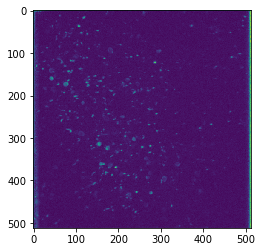

In [324]:
plt.imshow(in_data_corr)

/opt/conda/envs/pytorch-py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  """Entry point for launching an IPython kernel.


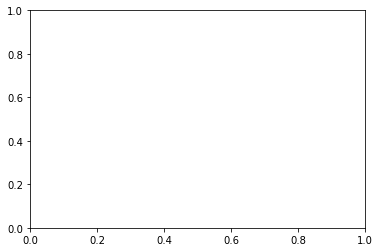

In [325]:
plt.hold()

/opt/conda/envs/pytorch-py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  """Entry point for launching an IPython kernel.


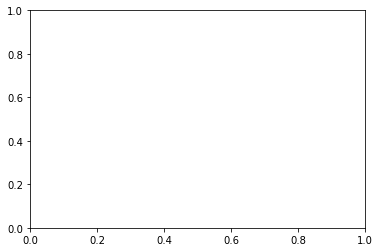

In [326]:
plt.hold()

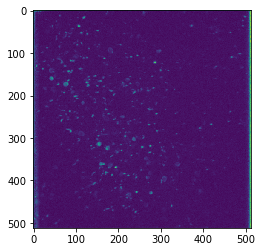

In [327]:
plt.imshow(in_data_corr)

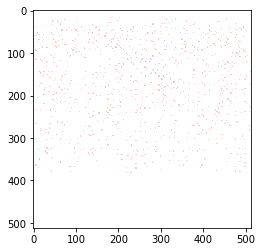

In [328]:
plt.imshow(overlap, alpha=0.2)

In [329]:
plt.close()

In [331]:
fig = plt.figure(figsize=(12,12), frameon=False)

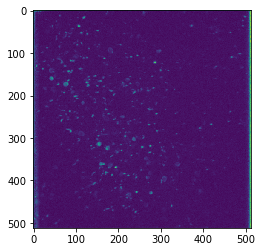

In [332]:
plt.imshow(in_data_corr)

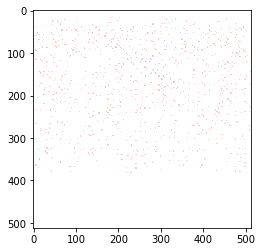

In [333]:
plt.imshow(overlap, alpha=0.2)

In [334]:
from matplotlib.colors import colorConverter

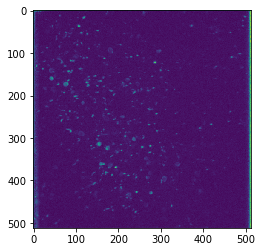

In [338]:
plt.imshow(in_data_corr)

In [339]:
import numpy.ma as ma

In [350]:
mask = ma.masked_where(overlap==0, overlap)

In [341]:
mask

masked_array(data =
 [[[0.0 0.0 0.0 0.0]
  [0.0 0.0 0.0 0.0]
  [0.0 0.0 0.0 0.0]
  ..., 
  [0.0 0.0 0.0 0.0]
  [0.0 0.0 0.0 0.0]
  [0.0 0.0 0.0 0.0]]

 [[0.0 0.0 0.0 0.0]
  [0.0 0.0 0.0 0.0]
  [0.0 0.0 0.0 0.0]
  ..., 
  [0.0 0.0 0.0 0.0]
  [0.0 0.0 0.0 0.0]
  [0.0 0.0 0.0 0.0]]

 [[0.0 0.0 0.0 0.0]
  [0.0 0.0 0.0 0.0]
  [0.0 0.0 0.0 0.0]
  ..., 
  [0.0 0.0 0.0 0.0]
  [0.0 0.0 0.0 0.0]
  [0.0 0.0 0.0 0.0]]

 ..., 
 [[0.0 0.0 0.0 0.0]
  [0.0 0.0 0.0 0.0]
  [0.0 0.0 0.0 0.0]
  ..., 
  [0.0 0.0 0.0 0.0]
  [0.0 0.0 0.0 0.0]
  [0.0 0.0 0.0 0.0]]

 [[0.0 0.0 0.0 0.0]
  [0.0 0.0 0.0 0.0]
  [0.0 0.0 0.0 0.0]
  ..., 
  [0.0 0.0 0.0 0.0]
  [0.0 0.0 0.0 0.0]
  [0.0 0.0 0.0 0.0]]

 [[0.0 0.0 0.0 0.0]
  [0.0 0.0 0.0 0.0]
  [0.0 0.0 0.0 0.0]
  ..., 
  [0.0 0.0 0.0 0.0]
  [0.0 0.0 0.0 0.0]
  [0.0 0.0 0.0 0.0]]],
             mask =
 [[[False False False False]
  [False False False False]
  [False False False False]
  ..., 
  [False False False False]
  [False False False False]
  [False False False F

In [351]:
overlap_mask = ma.masked_array(overlap,mask)

In [343]:
overlap_mask

masked_array(data =
 [[[0.0 0.0 0.0 0.0]
  [0.0 0.0 0.0 0.0]
  [0.0 0.0 0.0 0.0]
  ..., 
  [0.0 0.0 0.0 0.0]
  [0.0 0.0 0.0 0.0]
  [0.0 0.0 0.0 0.0]]

 [[0.0 0.0 0.0 0.0]
  [0.0 0.0 0.0 0.0]
  [0.0 0.0 0.0 0.0]
  ..., 
  [0.0 0.0 0.0 0.0]
  [0.0 0.0 0.0 0.0]
  [0.0 0.0 0.0 0.0]]

 [[0.0 0.0 0.0 0.0]
  [0.0 0.0 0.0 0.0]
  [0.0 0.0 0.0 0.0]
  ..., 
  [0.0 0.0 0.0 0.0]
  [0.0 0.0 0.0 0.0]
  [0.0 0.0 0.0 0.0]]

 ..., 
 [[0.0 0.0 0.0 0.0]
  [0.0 0.0 0.0 0.0]
  [0.0 0.0 0.0 0.0]
  ..., 
  [0.0 0.0 0.0 0.0]
  [0.0 0.0 0.0 0.0]
  [0.0 0.0 0.0 0.0]]

 [[0.0 0.0 0.0 0.0]
  [0.0 0.0 0.0 0.0]
  [0.0 0.0 0.0 0.0]
  ..., 
  [0.0 0.0 0.0 0.0]
  [0.0 0.0 0.0 0.0]
  [0.0 0.0 0.0 0.0]]

 [[0.0 0.0 0.0 0.0]
  [0.0 0.0 0.0 0.0]
  [0.0 0.0 0.0 0.0]
  ..., 
  [0.0 0.0 0.0 0.0]
  [0.0 0.0 0.0 0.0]
  [0.0 0.0 0.0 0.0]]],
             mask =
 [[[False False False False]
  [False False False False]
  [False False False False]
  ..., 
  [False False False False]
  [False False False False]
  [False False False F

In [344]:
plt.close()

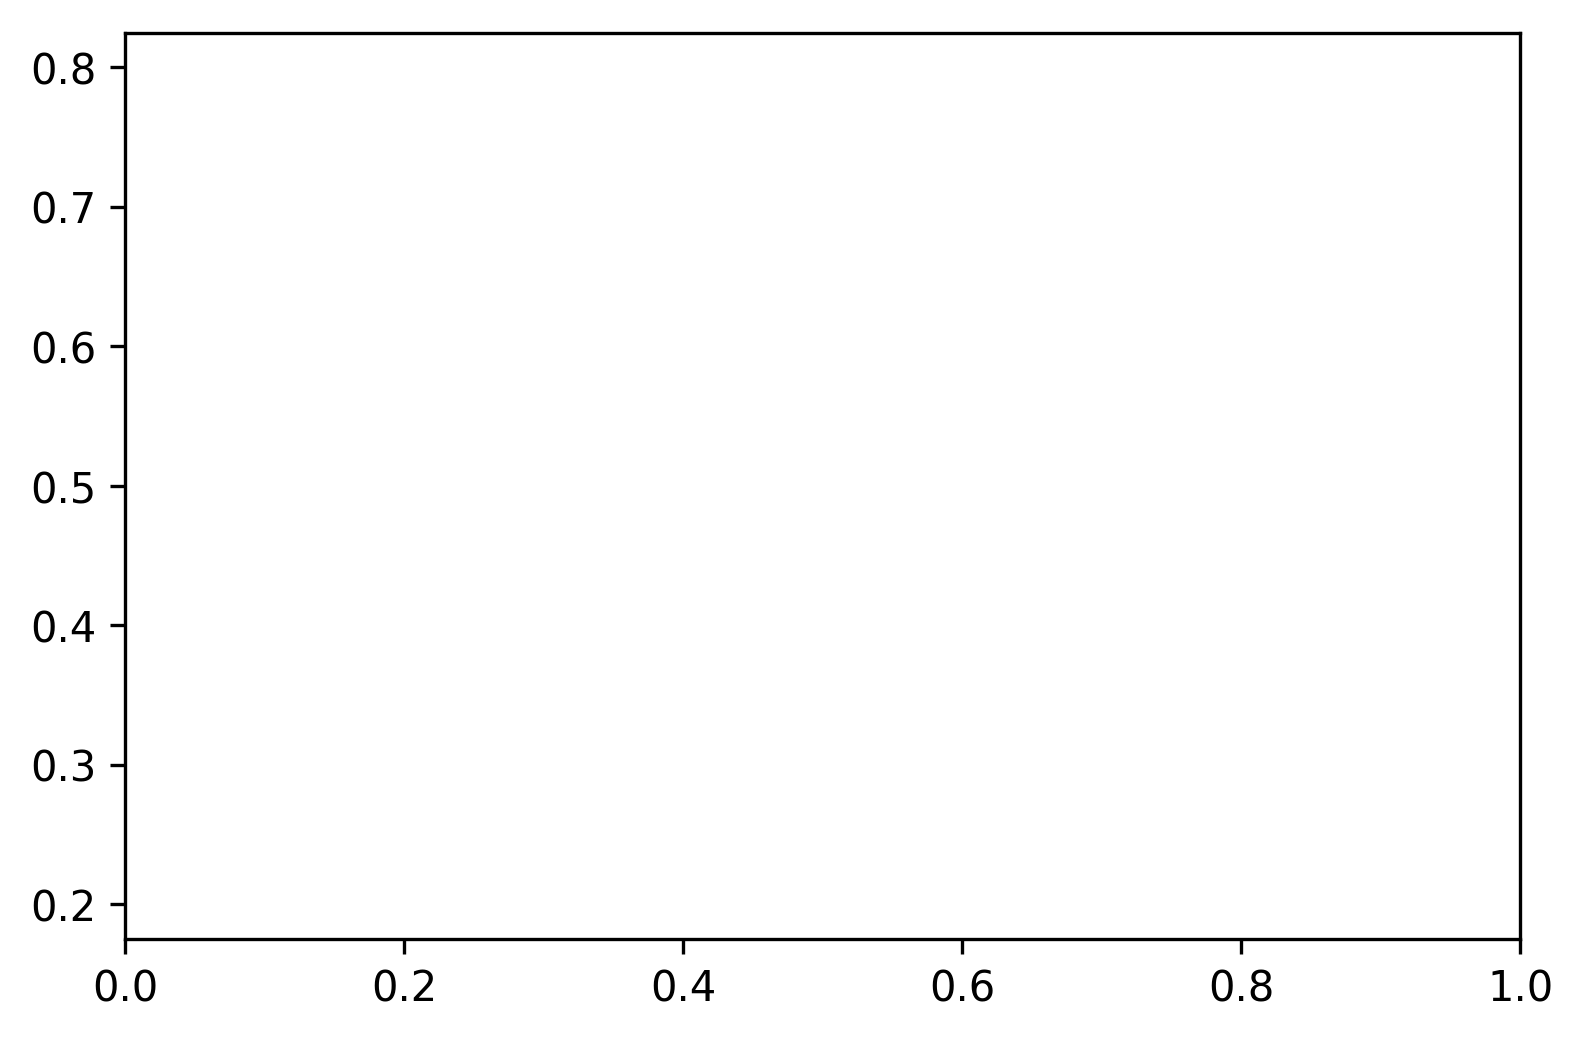

In [345]:
plt.figure(dpi=300)
y, x = np.mgrid[1:513,1:513]
plt.axes().set_aspect('equal', 'datalim')
plt.set_cmap(plt.gray())

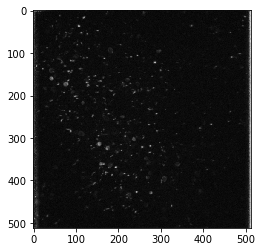

In [355]:
plt.imshow(in_data_corr, cmap='gray', interpolation=None)

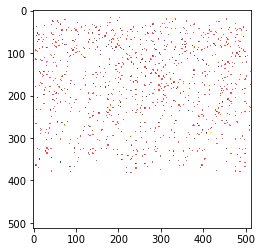

In [356]:
plt.imshow(overlap_mask, cmap='jet', interpolation=None, alpha=0.7)

In [357]:
plt.show()

In [358]:
plt.close()

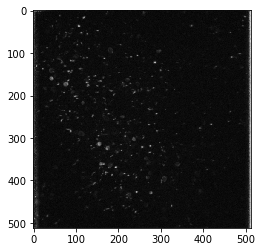

In [359]:
plt.imshow(in_data_corr)

In [360]:
hold on

SyntaxError: invalid syntax (<ipython-input-360-d32e5eabb5c6>, line 1)

In [361]:
plt.hold on

SyntaxError: invalid syntax (<ipython-input-361-bee199b7de74>, line 1)

/opt/conda/envs/pytorch-py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  """Entry point for launching an IPython kernel.
/opt/conda/envs/pytorch-py36/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/opt/conda/envs/pytorch-py36/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


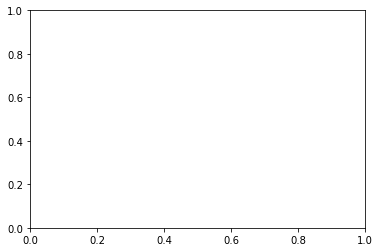

In [362]:
plt.hold(True)

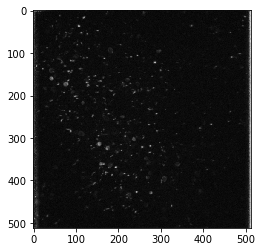

In [363]:
plt.imshow(in_data_corr)

In [372]:
overlap[0][0]

array([ 0.,  0.,  0.,  0.])

1.0

In [376]:
plt.close()

In [429]:
ov2 = np.dstack((overlap, np.ones((512,512))*0.7))

In [421]:
plt.close()

/opt/conda/envs/pytorch-py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  """Entry point for launching an IPython kernel.
/opt/conda/envs/pytorch-py36/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/opt/conda/envs/pytorch-py36/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


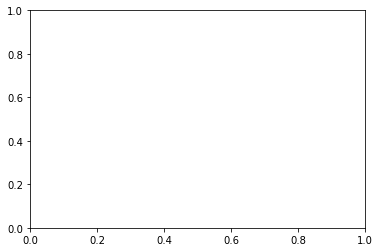

In [422]:
plt.hold(True)

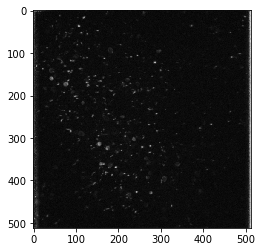

In [423]:
plt.imshow(in_data_corr)

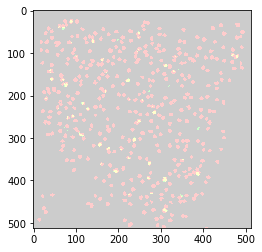

In [424]:
plt.imshow(ov2)

In [395]:
plt.close()

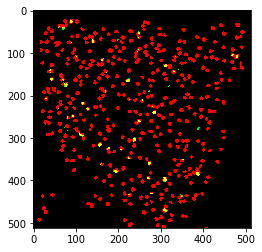

In [396]:
plt.imshow(overlap)

In [400]:
ov2[0][0]

array([ 0.,  0.,  0.,  0.])

In [401]:
ov2.max()

1.0

In [403]:
ov2[ov2==1].shape

(29880,)

In [404]:
ov2.shape

(512, 512, 4)

In [405]:
in_data_corr.shape

(512, 512)

In [408]:
overlap.shape

(512, 512, 3)

In [409]:
ov2.shape

(512, 512, 4)

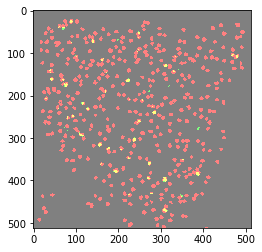

In [412]:
plt.imshow(ov2)

In [413]:
plt.close()

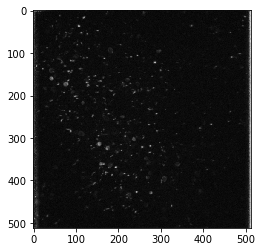

In [431]:
i = plt.imshow(in_data_corr)

/opt/conda/envs/pytorch-py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  """Entry point for launching an IPython kernel.
/opt/conda/envs/pytorch-py36/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/opt/conda/envs/pytorch-py36/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


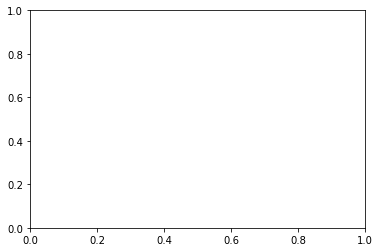

In [415]:
plt.hold(True)

In [416]:
plt.close()

/opt/conda/envs/pytorch-py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  """Entry point for launching an IPython kernel.
/opt/conda/envs/pytorch-py36/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/opt/conda/envs/pytorch-py36/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


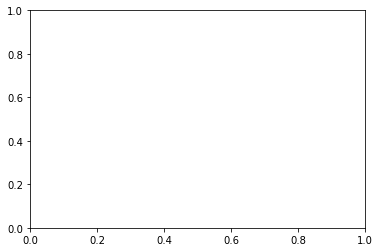

In [417]:
plt.hold(True)

TypeError: unhashable type: 'numpy.ndarray'

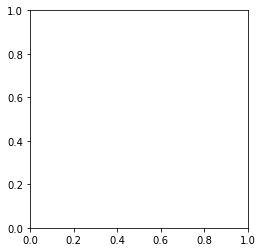

In [432]:
plt.imshow(i,ov2)

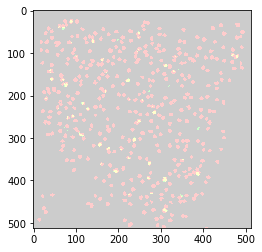

In [428]:
plt.imshow(ov2)

In [433]:
plt.set(in_data_corr, ov2)

AttributeError: module 'matplotlib.pyplot' has no attribute 'set'

In [438]:
overlap[overlap==0]

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [456]:
import data
from datatools import RandomFlip, TypeConversion 
from torchvision import transforms 
from torch.utils.data import DataLoader 
import numpy as np 
transform = transforms.Compose([    
    RandomFlip(),    
    TypeConversion(np.float32, np.long) ]) 
dat = np.load('data_interpolated.npz') 
train = ListDataset(*dat['train'], transform=transform) 
val = ListDataset(*dat['validation']) 
trainloader = DataLoader( train, shuffle=True, batch_size=1) 
valloader = DataLoader(val, shuffle=True) 
for x, y in trainloader:    
    print(x.size(), y.size())

IndentationError: unexpected indent (data.py, line 45)